# Importar bibliotecas e dados / Criar classe

In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

import statsmodels.formula.api as smf
import statsmodels.api as sm

from scipy import stats

In [3]:
df = pd.read_csv("SENIC.csv")
df.head()

,id,tempo,idade,risco_infeccao,cultura,x_ray,numero_camas,afiliacao,regiao,census,enfermeiras,servicos
0,1,7.13,55.7,4.1,9.0,39.6,279,2,4,207,241,60.0
1,2,8.82,58.2,1.6,3.8,51.7,80,2,2,51,52,40.0
2,3,8.34,56.9,2.7,8.1,74.0,107,2,3,82,54,20.0
3,4,8.95,53.7,5.6,18.9,122.8,147,2,4,53,148,40.0
4,5,11.20,56.5,5.7,34.5,88.9,180,2,1,134,151,40.0


In [4]:
class Multiple_Regression:
    def __init__(self, data : "dataframe", attributes : list, target : str, categorize = False, category = None):
        self.df = data
        self.features = attributes
        self.dict_features = {i: feat for i, feat in enumerate(['intercept'] + self.features)}
        self.categorize = categorize      
        if(categorize):
            self.target = target
            self.category = category
            self.groups = data[category].sort_values().unique()
            self.dict_categ = self.categ_data(data, category)

        self.X = self.get_data(categorize = False)
        self.XTX_inv = np.linalg.inv(self.X.T @ self.X)
        self.H = self.X @ self.XTX_inv @ self.X.T
        self.Y = self.df[target]
        self.residual = None
        
        self.model_SKL = self.MR_SKL()
        self.results = self.get_results()
        self.stats = self.stats_model()
        
    def categ_data(self, data, category = None):  
        data_dict = {}
        
        for group in self.groups:
            data_dict[group] = data.loc[data[category] == group]
        return data_dict

    def get_data(self, categorize = False, categories = None):
        if categorize:
            matrix_dict = {}
            
            if categories == None or categories == 'all':
                groups = self.groups
            else:
                groups = categories
                
            for group in groups:
                predictors = self.df.loc[df[self.category] == group][self.features]
                X = np.concatenate([np.ones((predictors.shape[0], 1)), predictors], axis=1)
                
                XTX_inv = np.linalg.inv(X.T @ X)
                H = X @ XTX_inv @ X.T
                Y = self.df.loc[df[self.category] == group][self.target]
                
                y_hat = H @ Y
                I_H = (np.eye(X.shape[0]) - H)
                residuals = I_H @ Y 
                
                beta_hat = XTX_inv @ X.T @ Y
                
                matrix_dict[group] = {'X' : X,
                                      'XTX_inv' : XTX_inv,
                                      'H' : H,
                                      'Y' : Y,
                                      'y_hat' : y_hat,
                                      'e' : residuals,
                                      'b_hat' : beta_hat}
            return matrix_dict
        
        predictors = self.df[self.features]
        predictors = np.concatenate([np.ones((predictors.shape[0], 1)), predictors], axis=1)
        return predictors
            
    def MR_SKL(self):
        # X_SK = sm.add_constant(df_model_A) 
        model = sm.OLS(self.Y, self.X).fit() 
        return model
    
    def summary_SKL(self):
        display(self.model_SKL.summary())
    
    def get_results(self):
        results = {}

        beta_hat = self.XTX_inv @ self.X.T @ self.Y
        I_H = (np.eye(self.X.shape[0]) - self.H)
        J = np.ones(self.X.shape[0])
        n = self.X.shape[0]
        p = self.X.shape[1] - 1
        
        # e = (I - H) @ Y
        e = I_H @ self.Y
        
        # SSR = Y.T @ [H - J/N) @ Y 
        SSR = self.Y.T @ (self.H - J/self.X.shape[0]) @ self.Y
        # SSE = Y.T @ (I - H) @ Y = Y.t @ e 
        SSE = self.Y.T @ e
        SST = SSR + SSE
        
        if(p == 1) : p += 1
        MSR = SSR / (p - 1)
        MSE = SSE / (n - p)

        # Covariance matrix - principal diagonal gives S^2
        cov_matrix = MSE * self.XTX_inv
        se_matrix = np.sqrt(np.diag(cov_matrix))     
        
        r_squared = 1 - (SSE / SST)
        F_obs = MSR / MSE 
        p_values = beta_hat / se_matrix
        
        results['beta_hat'] = beta_hat
        results['SE'] = se_matrix
        results['SS'] = { "SSR" : SSR, "SSE" : SSE, "SST" : SST}
        results['MS'] = {"MSR" : MSR, "MSE" : MSE}
        results['Stats'] = {'r^2' : r_squared, 'F' : F_obs, 'pval' : p_values}
        
        self.residuals = e
        
        return results
    
    def plot_results(self, type_plot, *args, **kwargs):
        if type_plot == 'scatter':
            self.__plot_scatter(*args, **kwargs)
        elif type_plot == 'residuals':
            self.__plot_residuals(*args, **kwargs)
        elif type_plot == 'qq':
            self.__qq_plot(*args, **kwargs)
        else:
            print("Invalid plot type. Supported types: 'scatter', 'residuals', 'qq'")
    
    def check_categories(self, categories : list):
        if categories == 'all':
            return True
            
        s = set(self.groups)
        s1 = set(categories)

        if not s1.issubset(s):
            print("Invalid categories!\n")

        return s1.issubset(s)
        
    def __plot_scatter(self, categories = None, plot_size=(4, 4)):
        if categories and not self.check_categories(categories): return None
        
        def plot(df, title):
            g = sns.pairplot(df[self.features], diag_kind='kde', height=plot_size[1], aspect=plot_size[0]/plot_size[1])
            g.map_upper(sns.kdeplot, fill=True, thresh=0, levels=100, cmap="mako")
            g.map_lower(sns.regplot, color=".3", line_kws=dict(color="r"))
            g.fig.suptitle(title, y=1.02)
    
        if categories:
            if (categories == 'all') and (self.categorize):
                categories = self.df[self.category].sort_values().unique()
            for categ in categories:
                plot(self.dict_categ[categ], title=f"Análise features - {self.category.title()} {categ}")
                plt.show() 
        else:
            plot(self.df, title="Análise features")
            plt.show()
    
    def __plot_residuals(self, categories = None):
        if categories and not self.check_categories(categories): return None
        
        def __plot_res(Y_hat, Residuals, X, Results, Category):
            plt.figure(figsize=(12, 4))
            plt.subplot(1, 2, 1)
            plt.scatter(Y_hat, Residuals, alpha=0.8)
            
            plt.axhline(y=0, color='r', linestyle='--')

            title = 'Resíduos - ' 
            if categories: title = title + 'Região ' + str(Category)
            else: title = title + Category
            plt.title(title)
            plt.xlabel('Ŷ (Resposta ajustada)')
            plt.ylabel('Resíduos')
            
            plt.subplot(1, 2, 2)
            
            for i in range(1, X.shape[1]):
                plt.scatter(X[:, i], Residuals, label=f'X{i} = {self.dict_features[i]}', alpha=0.8)
            
            plt.axhline(y=0, color='r', linestyle='--')
            title = r"$\hat{Y} = "
            for i, var in enumerate(Results):
                if i:
                    title = title + f"{var : .2f}" + r"*X" + f"{i}"
                    if(i < len(Results) - 1):
                         title = title + " +"
                else: title = title + f"{var : .2f} +"
            
            plt.title(title + "$")
            plt.xlabel('Valor da variável preditora')
            plt.ylabel('Resíduos')
            plt.legend(bbox_to_anchor = (1,1))
            
            plt.tight_layout()
            plt.show()

        if categories: 
            categ_dict = self.get_data(categorize = True, categories = categories)
            for categ, data in categ_dict.items():
              __plot_res(Y_hat = data['y_hat'], Residuals = data['e'], X = data['X'], Results = data['b_hat'], Category = categ)
        else : __plot_res(Y_hat = self.H @ self.Y, Residuals = self.residuals, X = self.X, Results = self.results['beta_hat'], Category = 'Todas as regiões')
            
       

    def __qq_plot(self, categories = None):
        if categories and not self.check_categories(categories): return None
        
        def __qq(Residuals, Category):
            plt.figure(figsize=(6, 6))
            stats.probplot(Residuals, dist="norm", plot=plt)
    
            sm.qqline(plt.gca(), line='45', fmt='r--', alpha=0.5, color = "green", label='Distribuição Normal')
            plt.gca().set_xlim([-3, 3])
            
            plt.axhline(y=1000, color='red', label='Dados')
            
            title = 'QQ plot Resíduos - ' 
            if categories: title = title + 'Região ' + str(Category)
            else: title = title + Category
            
            plt.title(title)
            plt.legend()
            plt.show()
        
        if categories:
            categ_dict = self.get_data(categorize = True, categories = categories)
            for categ, data in categ_dict.items():
              __qq(Residuals = data['e'], Category = categ)
        else : __qq(Residuals = self.residuals, Category = 'Todas as regiões')
            
            
    def stats_model(self):
        stats_dict = {}
        dof = len(self.df) - 1
        alpha = 0.05
        
        for i, beta in enumerate(self.results['beta_hat']):
            se = self.results['SE'][i]
            
            t = beta/se
            p = (1 - stats.t.cdf(abs(t), dof)) * 2
            
            t_ic = stats.t.ppf((1 - 0.5*alpha), df = dof)
            IC = (beta - t_ic*se, beta + t_ic*se)
            stats_dict[i] = [beta, se, t, p, IC]
        
        return stats_dict
    
    def Y_hat(self, model = ""):
        Y_hat = "Ŷ = "
        for i, beta in enumerate(self.results['beta_hat']):
            Y_hat += f"{beta:.3f}"
            if i:
                if(i < len(self.results['beta_hat']) - 1) : Y_hat += f"*X{i} + "
                else: Y_hat += f"*X{i}"
            else: Y_hat += " + "
        return model + Y_hat
    
    # Stats_possible: ['Y_hat', 'StdErr', 'MS', 'Stats']
    def get_stats(self, model = "", stats = None):
        dict_stats = {}
            
        Y_hat = model + "Ŷ = "
        for i, beta in enumerate(self.results['beta_hat']):
            Y_hat += f"{beta:.3f}"
            if i:
                if(i < len(self.results['beta_hat']) - 1) : Y_hat += f"*X{i} + "
                else: Y_hat += f"*X{i}"
            else: Y_hat += " + "
    
        StdErr = model + "SE:\n"
        for i, se in enumerate(self.results['SE']):
            StdErr += f"B{i}:\t{se:.3f}\n"
        
        Stats = model + "Stats:\n"
        Stats += f"r²:\t{self.results['Stats']['r^2']:.3f}"
        
        Stats += f"\nP_valores:\n"
        for i, p in enumerate(self.results['Stats']['pval']):
            Stats += f"X{i}:\t{p:.3f}\n"
        
        dict_stats['Y_hat'] = Y_hat
        dict_stats['StdErr'] = StdErr
        dict_stats['MS'] = model + f"\nMSR:\t{self.results['MS']['MSR'] :.3f}\nMSE:\t{self.results['MS']['MSE']:.3f}"
        dict_stats['Stats'] = Stats
    
        if(stats):
            print("")
            for stat in stats:
                print(dict_stats[stat])
        else:
            print("")
            for statistics in dict_stats.values():
                print(statistics)
  
def get_label(pca, lr):

    title = r"$\hat{X} = "
    for i, var in enumerate(pca):
        title = title + f"{var : .2f}" + r"*X" + f"{i}"
        if(i < len(pca) - 1):
             title = title + " +"


    title_y = r"$\hat{Y} = "
    for i, var in enumerate(lr):
        if i:
            title_y = title_y + f"{var : .2f}" + r"*X" + f"{i}"
            if(i < len(lr) - 1):
                 title_y = title_y + " +"
        else: title_y = title_y + f"{var : .2f} +"
        
    return title + "$\n" + title_y + "$"


def apply_pca(data, columns, plot = False):
    subset_data = data[columns]
    standardized_data = StandardScaler().fit_transform(subset_data)

    pca = PCA()
    principal_components = pca.fit_transform(standardized_data)

    pc_df = pd.DataFrame(data=principal_components, columns=[f'PC{i+1}' for i in range(len(columns))])
    pc_df = pd.concat([pc_df, subset_data], axis=1)

    explained_variance_ratio = pca.explained_variance_ratio_
    
    if(plot):
        cumulative_explained_variance = explained_variance_ratio.cumsum()
        plt.plot(range(1, len(columns) + 1), cumulative_explained_variance, marker='o')
        plt.title('Variância Explicada Acumulada')
        plt.xlabel('Número de Componentes Principais')
        plt.ylabel('Variância Explicada Acumulada')
        plt.show()

    return pc_df, explained_variance_ratio

def plot_corr(data, variables):
    if(variables): data = data[variables]
    
    fig, axs = plt.subplots(1, 2, figsize=(20,7))
    fig.suptitle("Distribuição das variáveis")
       
    corr_pearson = data.corr(method='pearson')
    corr_spearman = data.corr(method='spearman')
    
    ax = axs[0]
    sns.heatmap(corr_pearson, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title("Matriz de Correlação de Pearson")
    
    ax = axs[1]
    sns.heatmap(corr_spearman, annot=True, cmap='coolwarm', fmt=".2f", ax=ax)
    ax.set_title("Matriz de Correlação de Spearman")
    
    plt.tight_layout()

In [5]:
model_A = ['idade', 'risco_infeccao', 'servicos']
MR_A = Multiple_Regression(data = df, attributes = model_A, target = 'tempo')

model_B = ['numero_camas', 'risco_infeccao', 'servicos']
MR_B = Multiple_Regression(data = df, attributes = model_B, target = 'tempo')

model_3 = ['idade', 'numero_camas', 'risco_infeccao', 'servicos']
MR_3 = Multiple_Regression(data = df, attributes = model_3, target = 'tempo')

model_3b = ['servicos']
MR_3b = Multiple_Regression(data = df, attributes = model_3b, target = 'tempo')

model_4 = ['idade',  'cultura', 'census', 'servicos']
MR_4 = Multiple_Regression(data = df, attributes = model_4, target = 'tempo', categorize=True, category='regiao')

# Exercício 2

Modelo A = Idade do paciente, Probabilidade do risco de infecção e Porcentagem de serviços fornecidos.

Modelo B = Número de leitos, Probabilidade do risco de infecção e Porcentagem de serviços fornecidos.

***

***
## a)

É possível observar na figura abaixo, relativa ao Modelo A, que as únicas variáveis com correlação significativa são serviços x risco de infecção. A variável idade mostra-se pouco correlacionada com as outras duas variáveis. Além disso, nota-se que as variáveis tem distribuição aproximadamente simétrica em todos os casos.

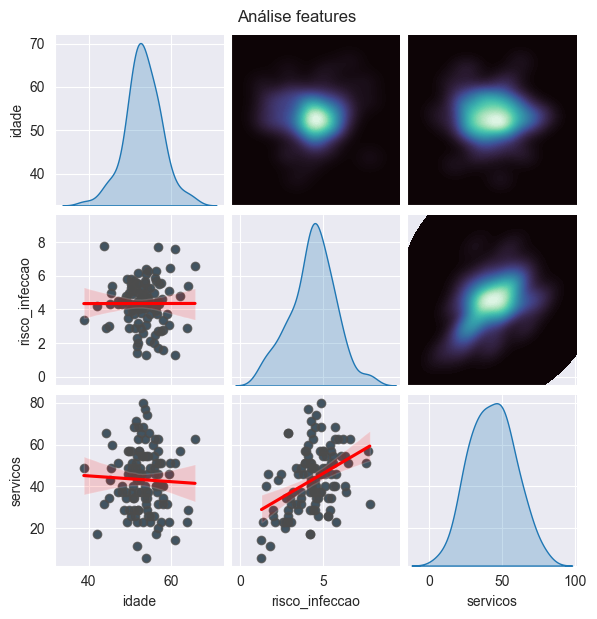

In [76]:
MR_A.plot_results(type_plot="scatter", plot_size = (2,2))

Na imagem abaixo (referente ao Modelo B) é possível observar que todas as variáveis apresentam considerável correlação entre si, evidenciado pela linha vermelha nos scatter plots. Além disso, é válido destacar que a distribuição da feature "número de leitos" apresentam certa assimetria, com os valores concentrados entre o intervalo [0, 500].

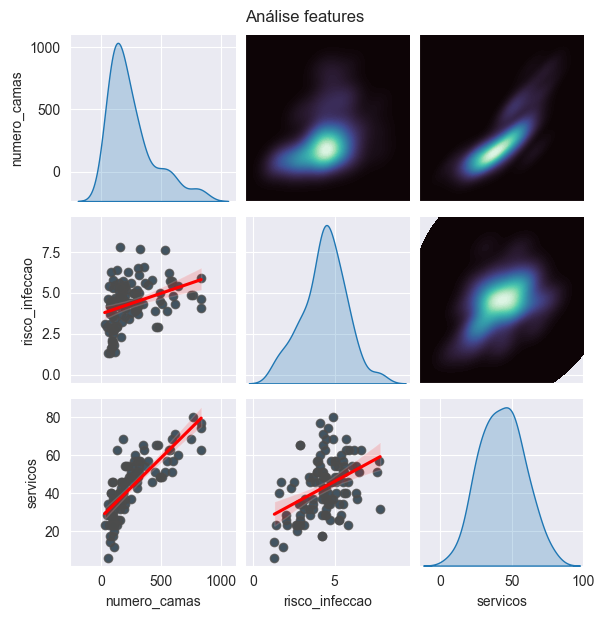

In [61]:
MR_B.plot_results(type_plot="scatter", plot_size = (2,2))

***

## b) & c)

Abaixo são relacionados os modelos de regressão linear múltipla para cada um dos casos:

In [209]:
MR_A.get_stats(model="Modelo A: ", stats=['Y_hat']), MR_B.get_stats(model="Modelo B: ", stats=['Y_hat'])


Modelo A: Ŷ = 1.386 + 0.084*X1 + 0.658*X2 + 0.022*X3

Modelo B: Ŷ = 6.467 + 0.003*X1 + 0.648*X2 + -0.009*X3


(None, None)

In [210]:
MR_A.get_stats(model="Modelo A: ", stats=['Stats']), MR_B.get_stats(model="Modelo B: ", stats=['Stats'])


Modelo A: Stats:
r²:	0.345
P_valores:
X0:	0.746
X1:	2.529
X2:	5.451
X3:	2.038


Modelo B: Stats:
r²:	0.341
P_valores:
X0:	10.561
X1:	2.384
X2:	5.337
X3:	-0.565


(None, None)

Além disso, acima são relacionados os valores de R², que em ambos os casos ficou em torno de 0.34, portanto, tomando como critério o coeficiente R², ambos so modelos performam de forma similar.
***

## d)

Abaixo são exibidos os resíduos em função da resposta ajustada de Ŷ, além de realizar a representação dos resíduos em relação à cada uma das variáveis, no plot da direita.

Nos dois modelos, A e B, é possível observar uma distribuição relativamente uniforme tanto ao longo dos diferentes valores de Ŷ, característico de resíduos com distribuição normal. Além disso, tanto para Ŷ quanto para as variávies X1, X2 e X3 observa-se um comportamento relativamente simetrico em relação à 0.

Modelo A


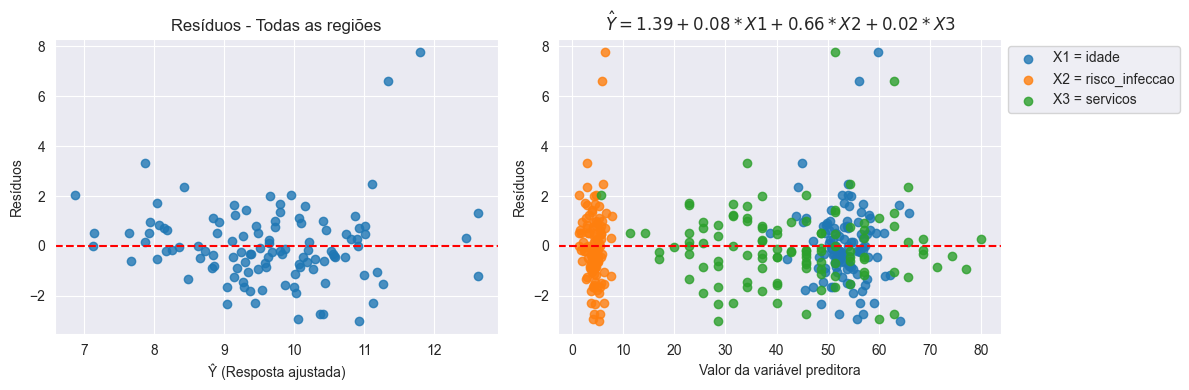

In [213]:
print('Modelo A')
MR_A.plot_results(type_plot="residuals")

Modelo B


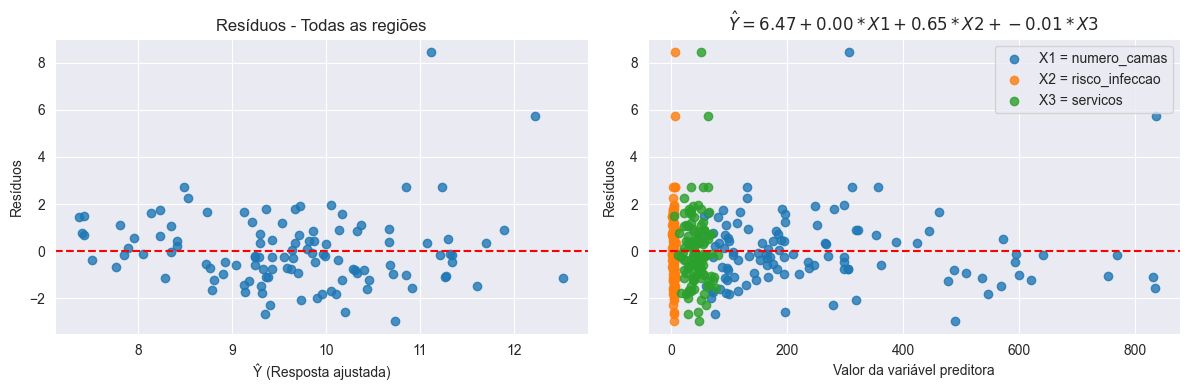

In [215]:
print('Modelo B')
MR_B.plot_results(type_plot="residuals")

***

## e)

Abaixo são plotados os QQ plots para ambos os modelos, com a linha verde sendo relativa a uma distribuição normal e a linha vermelha fitada nos dados, sendo evidente o coportamento similar de ambos os modelos.

Modelo A


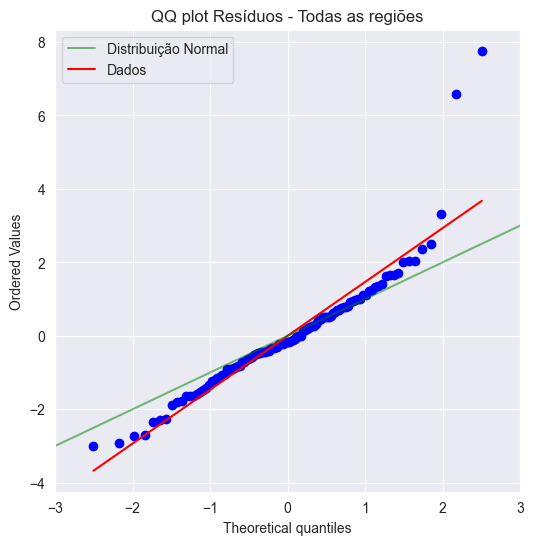

Modelo B


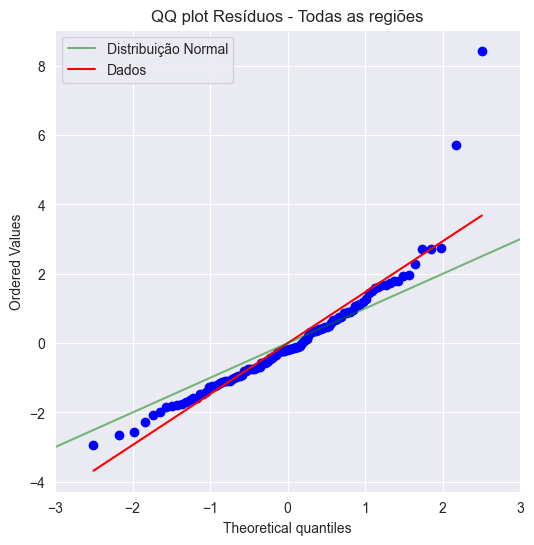

In [216]:
print("Modelo A")
MR_A.plot_results(type_plot='qq')
print("Modelo B")
MR_B.plot_results(type_plot='qq')

***
# Exercício 3

a) Na matriz de correlação abaixo é possível observar que, tanto no caso da Correlação de Pearson quanto na Correlação de Sprearman, as variáveis com correlação moderada/forte seriam serviços e número de camas, o que é razoável uma vez que hospitais maiores prestam maior número de serviços e contam com maior quantidade de leitos disponíveis.

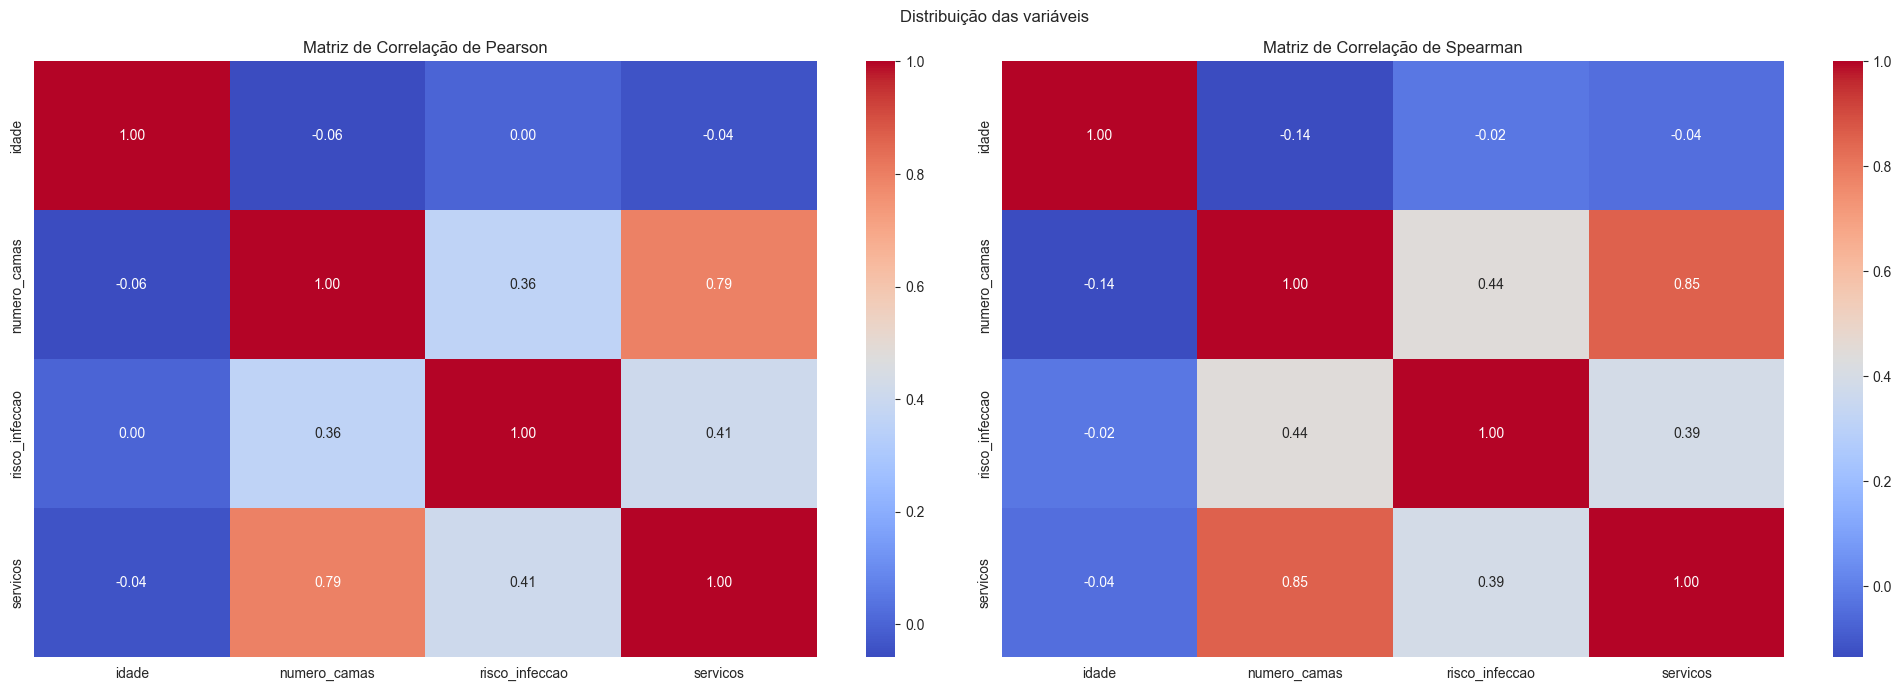

In [237]:
plot_corr(df, variables=model_3)

***
## b)

Abaixo é exibido o modelo somente com a variável "Porcentagem de serviços prestados", bem como o erro padrão associado a cada um dos estimadores.

In [247]:
(MR_3b.get_stats(model="Modelo 3b: ", stats=['Y_hat']), MR_3b.get_stats(model="Modelo 3b: ", stats=['StdErr']))


Modelo 3b: Ŷ = 7.719 + 0.045*X1

Modelo 3b: SE:
B0:	0.510
B1:	0.011


(None, None)

***
## c)

Abaixo é exibido o modelo somente com as 4 covariáveis, bem como o erro padrão associado a cada um dos estimadores.

In [249]:
(MR_3.get_stats(model="Modelo 3b: ", stats=['Y_hat']), MR_3.get_stats(model="Modelo 3b: ", stats=['StdErr']))


Modelo 3b: Ŷ = 1.814 + 0.087*X1 + 0.003*X2 + 0.641*X3 + -0.010*X4

Modelo 3b: SE:
B0:	1.820
B1:	0.032
B2:	0.001
B3:	0.118
B4:	0.016


(None, None)

***
## d) & e) <- TERMINAR!!!!!!!!!!!!!!

Enquanto no modelo simples, somente com a variável serviços, o coeficiente é igual a 0.045, com erro padrão 0.011, no modelo com as 4 covariáveis o coeficiente relativo à variável serviços é de -0.010 com erro padrão de 0.016.

Conforme exibido pela summary da biblioteca SKlearn, o p-valor para o modelo com 4 covariáveis é de 0.555

In [254]:
MR_3.summary_SKL(), MR_3b.summary_SKL()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempo   R-squared:                       0.382
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     16.71
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           1.09e-10
Time:                        17:43:02   Log-Likelihood:                -205.83
No. Observations:                 113   AIC:                             421.7
Df Residuals:                     108   BIC:                             435.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8136      1.828      0.992      0.323      -1.810       5.437
x1             0.0875      0.032      2.694      0.008       0.023       0.152
x2             0.0032      0.001      2.560      0.012       0.001       0.006
x3             0.6406      0.119      5.403      0.000       0.406       0.876
x4            -0.0095      0.016     -0.592      0.555      -0.041       0.022
==============================================================================
Omnibus:                       55.041   Durbin-Watson:                   2.218
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              241.501
Skew:                           1.610   Prob(JB):                     3.62e-53
Kurtosis:                       9.398   Cond. No.                     4.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  tempo   R-squared:                       0.126
Model:                            OLS   Adj. R-squared:                  0.119
Method:                 Least Squares   F-statistic:                     16.06
Date:                Fri, 17 Nov 2023   Prob (F-statistic):           0.000111
Time:                        17:43:02   Log-Likelihood:                -225.41
No. Observations:                 113   AIC:                             454.8
Df Residuals:                     111   BIC:                             460.3
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.7188      0.510     15.129      0.000       6.708       8.730
x1             0.0447      0.011      4.008      0.000       0.023       0.067
==============================================================================
Omnibus:                       69.105   Durbin-Watson:                   2.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              376.891
Skew:                           2.029   Prob(JB):                     1.44e-82
Kurtosis:                      10.973   Cond. No.                         138.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

(None, None)

***

## f)


In [255]:
MR_3.get_stats(model="Modelo 3", stats=['MS'])


Modelo 3
MSR:	52.140
MSE:	2.319


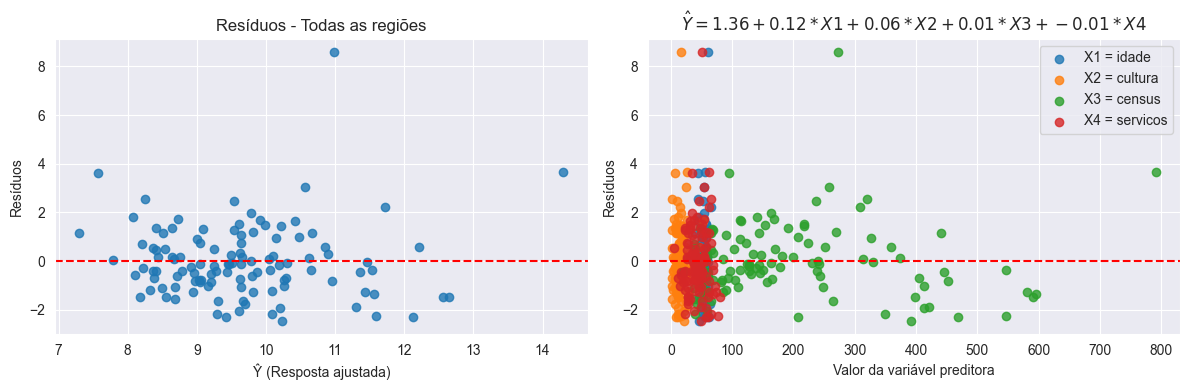

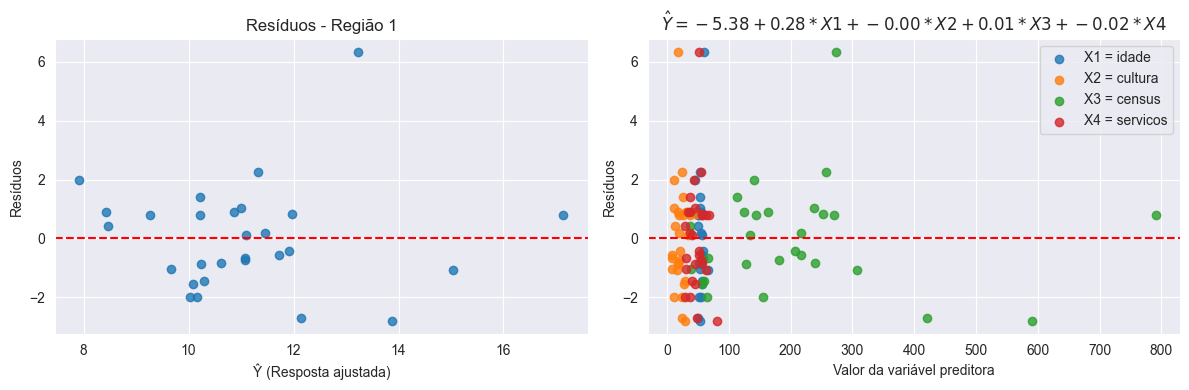

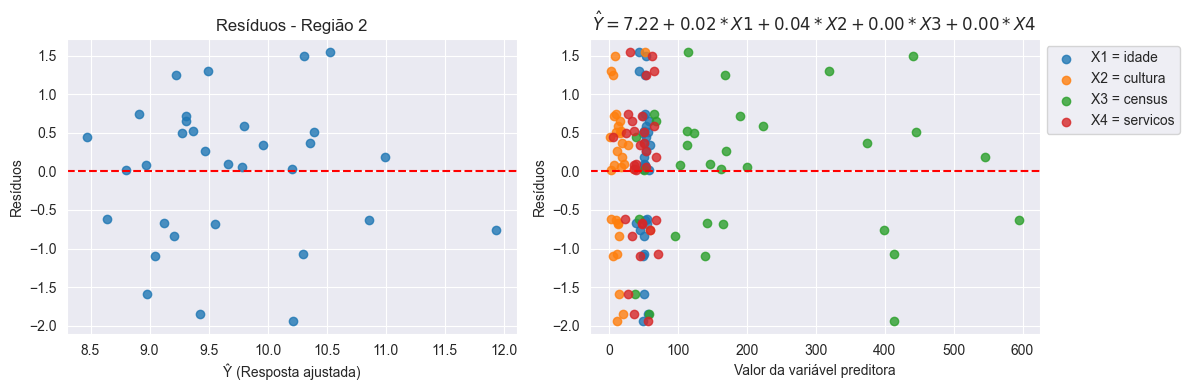

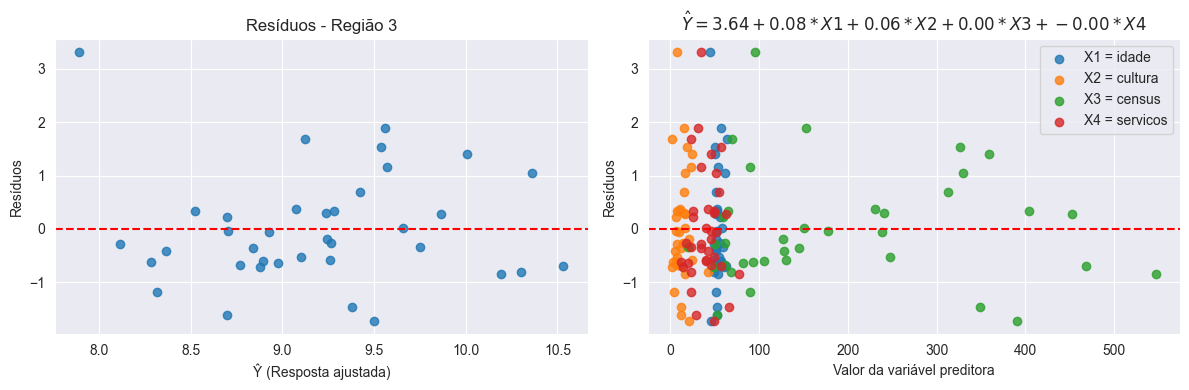

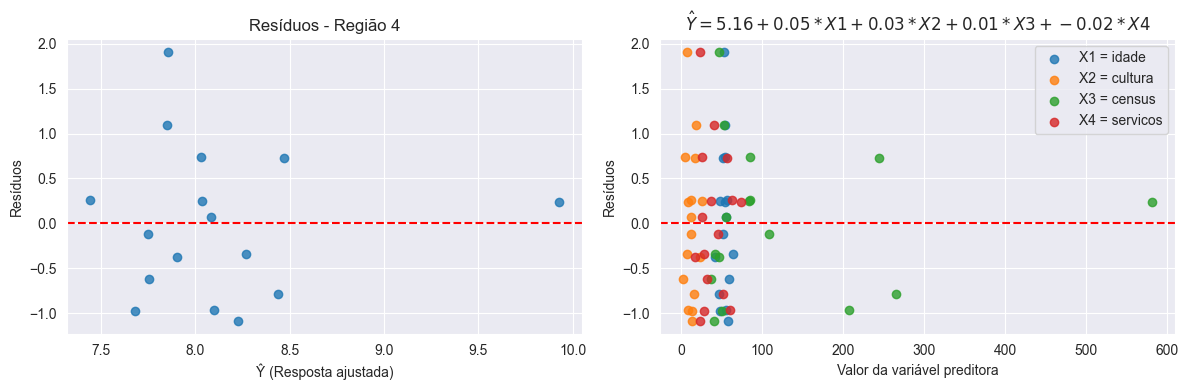

In [58]:


MR_4.plot_results(type_plot="residuals")
MR_4.plot_results(type_plot="residuals", categories='all')

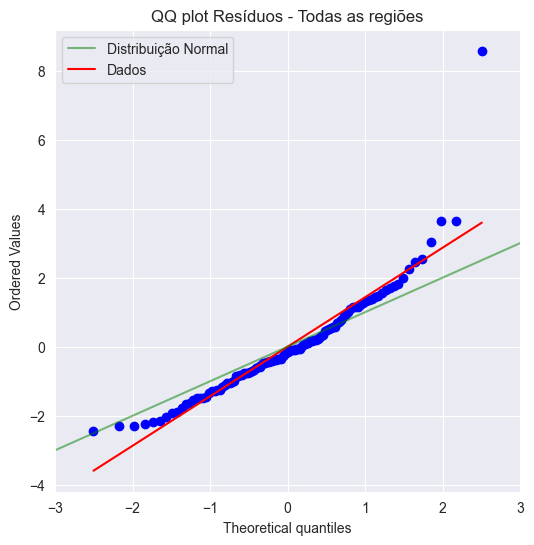

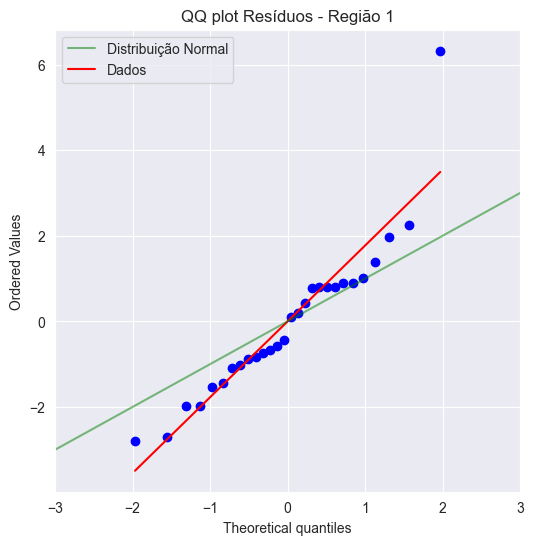

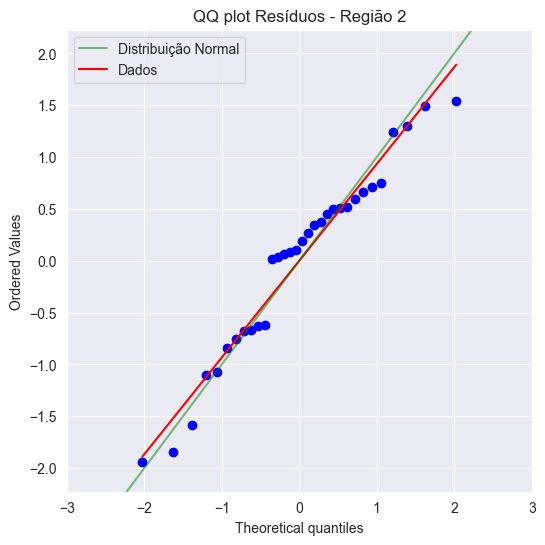

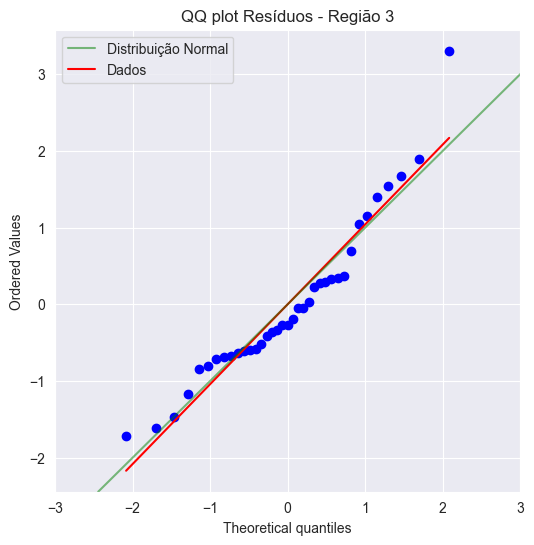

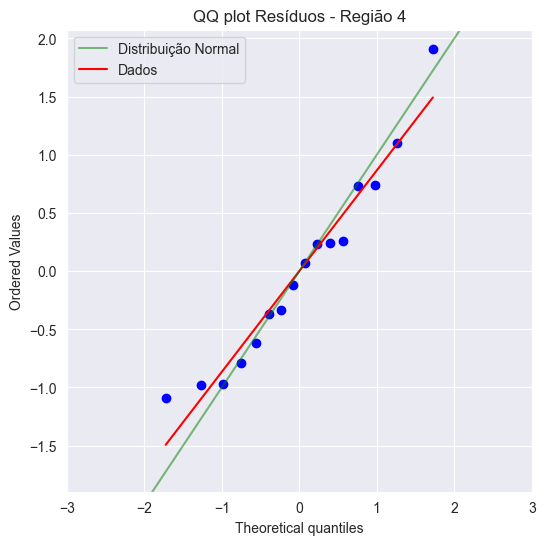

In [57]:
MR_4.plot_results(type_plot="qq")
MR_4.plot_results(type_plot="qq", categories='all')

# PCA

In [ ]:
data = df.copy()
columns_to_pca = model_A
result_df, explained_variance = apply_pca(data, columns_to_pca)

print("Variância Explicada por Componente Principal:")
print(explained_variance)

In [ ]:
dteste = MR_A.X.copy()
PCA = 0

for i, comp in enumerate(explained_variance):
    PCA =  PCA + dteste[:, i+1]*comp
   
dteste = np.column_stack((dteste, PCA))

X = dteste[:, 4].copy()
Y = df['tempo']
X = sm.add_constant(X)

model = sm.OLS(Y, X).fit()
model.summary()

In [ ]:
xlin = np.linspace(-2+ X[:,1].min(),X[:,1].max()+2,100) # x data for the theoretical line.
ytrue = model.params['const'] + model.params['x1']*xlin

label = get_label(explained_variance, [model.params['const'], model.params['x1']])
plt.plot(X[:,1],Y, 'o',markerfacecolor='white')
plt.plot(xlin,ytrue,'-',color='red',linewidth=1.4,label=label)
plt.legend();

OLSResults.mse_model
Mean squared error the model.
The explained sum of squares divided by the model degrees of freedom.

OLSResults.mse_resid
Mean squared error of the residuals.
The sum of squared residuals divided by the residual degrees of freedom.

OLSResults.mse_total
Total mean squared error.
The uncentered total sum of squares divided by the number of observations.

In [ ]:
print("Modelo PCA")
model.mse_model, model.mse_resid, model.mse_total

In [ ]:
print("Modelo Multinomial")
MR_A.model_SKL.mse_model, MR_A.model_SKL.mse_resid, MR_A.model_SKL.mse_total

In [ ]:
model_C = ['idade', 'numero_camas', 'risco_infeccao', 'servicos']
MR_B = Multiple_Regression(data = df, attributes = model_C, target = 'tempo')
MR_B.plot_residuals()

In [ ]:
MR_C = Multiple_Regression(data = df, attributes = ['servicos'], target = 'tempo')
MR_C.plot_residuals()

In [ ]:
model_A = ['idade', 'risco_infeccao', 'servicos']
model_B = ['numero_camas', 'risco_infeccao', 'servicos']

model_C = ['idade', 'numero_camas', 'risco_infeccao', 'servicos']

model_D = ['idade',  'cultura', 'census', 'servicos']